In [2]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera



#switch the .ipynb into .py so that it can import the data
#the easiest way to do this is get all the code into Jupyter then download the file as .py
# then rename the file and moved them all into approriate folder, 
# for me is within the site-packages/dataset directory
from dataset.lung_dataset import LungDataset  
from dataset.lung_model import UNet

In [3]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

In [5]:
# Create the dataset objects
train_path = Path(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/Task06_Lung/Task06_Lung/labelsTr/Task06_Lung/Preprocessed/train/")
val_path = Path(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/Task06_Lung/Task06_Lung/labelsTr/Task06_Lung/Preprocessed/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14484 train images and 1283 val images


In [6]:
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/14484 [00:00<?, ?it/s]

C:\Anaconda\envs\pytorch\Lib\site-packages\imgaug\imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


In [7]:
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([12971,  1513], dtype=int64))

In [8]:
fraction = uniques[1][0] / uniques[1][1]
fraction

8.573033707865168

In [9]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [10]:
weight_list[:50]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [11]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))                     


In [12]:
batch_size = 8#TODO
num_workers = 4# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [13]:
verify_sampler = next(iter(train_loader))  # Take one batch


In [14]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # ~ half the batch size 


tensor([False,  True, False,  True, False, False,  True, False])

In [25]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        pred = self(ct.float())
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct.float())
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, ct, pred, mask, name):
        
        results = []
        
        pred = pred > 0.5 # As we use the sigomid activation function, we threshold at 0.5
        
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [26]:
# Instanciate the model
model = TumorSegmentation()

In [27]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

In [28]:
import torch

# Get the number of GPUs available
n_gpus = torch.cuda.device_count()

print(f"You have {n_gpus} GPUs available.") # I only have 1 GPU, so 1

You have 1 GPUs available.


In [33]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 # I onyl have 1 GPU
trainer = pl.Trainer(
    devices=gpus, #replace gpus = gpus with devices =gpus
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=10) # increase for more accurate, decrease to reduce computational time

# took my laptop 4 hours with 10 epoch


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model, train_loader, val_loader)
# replace pred = self(ct) by pred = self(ct.float()) within the train and validation step

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 7.8 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


# Evaluation

In [35]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice



In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [39]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1283 [00:00<?, ?it/s]

In [41]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

#The Val Dice Score is: 0.22702382504940033
#In the context of image segmentation tasks in machine learning, 
# a Dice score close to 1 indicates perfect overlap (i.e., perfect segmentation),
# while a score close to 0 indicates no overlap. Closer to 1 is better
# This low score might be due to the low number of epoch = 10 instead of 30. 

The Val Dice Score is: 0.22702382504940033


# Visualization

In [42]:
THRESHOLD = 0.5

In [43]:
import nibabel as nib
import cv2

In [44]:
subject = Path(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/Task06_Lung/Task06_Lung/imagesTs/lung_013.nii.gz") #change this accordingly
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop


In [45]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)

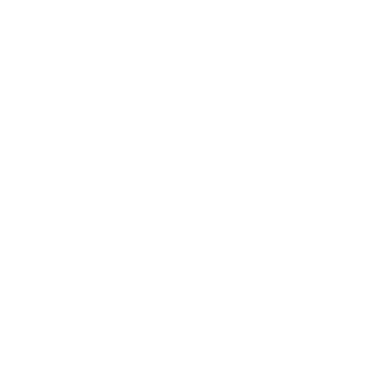

In [46]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation 
    
    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [47]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video